## Test ($\epsilon$,$\delta$)-differentially private synthetic data generation on simple dataset

In this notebook, we investigate the effect of enforcing differential privacy on usefulness of synthetic data. We firstly generate a simple dataset consisting of four independently unit-Gaussian distributed covariates $X$, and a Bernoulli-distributed outcome $Y$ with $E(Y)=logistic(\beta X)$

We make use of a public github library for [differentially private synthetic data generation](https://github.com/BorealisAI/private-data-generation)

Control parameters are as follows

In [1]:
############################################################
## File paths --------------------------------------------##
############################################################

# File paths for original and synthesised data sets
orig_path='/home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Original/'
synth_path='/home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Synthetic/'

# File path containing evaluate.py and PDG repository
pdg_path='/home/ec2-user/GRAIMatter/WP1/models/Synthetic_data/'

# File path to which outputs will be saved. Should contain directories called Figures, Tables
output_path='/home/ec2-user/GRAIMatter/WP1/reports/synthetic_data/'


############################################################
## Synth. generation methods and DP levels ---------------##
############################################################

# This parameter can be 'dp-wgan' or 'pate-gan' (GAN-based) or 'ron-gauss' (Gaussian projection)
#  Other options may be added. The parameter synth_extra governs extra parameters to be passed - 
#  see evaluate.py for details
synth_method='dp-wgan'; synth_extra='--sigma=0.8'
#synth_method='ron-gauss'; synth_extra='';

# We will consider epsilon-DP for these epsilon levels
dp_levels=[1,2,4,8]

# This parameter controls whether output from the system call to evaluate.py is shown in the notebook
show_output=True



############################################################
## Data parameters ---------------------------------------##
############################################################

# Random seed
random_seed=38273

# Simulate this many points
nx=10000

# Number of covariates
p=4

# Parameters of Gaussian distribution for IID covariates
mu=0
sigma=1

# Coefficients of logistic model for Y
beta0=[0.5,1,-1,-0.5]
beta=tuple([10*x for x in beta0])


Preliminary set-up as follows

In [2]:
# Preliminaries
import os
import logging
import pandas as pd
import numpy as np
import tensorflow as tf
import math
import csv
import matplotlib.pyplot as plt


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import losses
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate

# Silence warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(random_seed)

Some functions which will be useful

In [3]:
# Basic functions
def logistic1(x):
  return 1/(1+math.exp(-x))
logistic=np.vectorize(logistic1)
def logit1(x):
  return math.log(x/(1-x))
logit=np.vectorize(logit1)

# Sensitivity and specificity at range of cutoffs
def roc_xy(ypred,y):
    yt=sum(y); yl=len(y)
    opred=np.argsort(ypred) 
    sy=y[opred]; sp=ypred[opred]

    sens=1- (np.cumsum(sy)/yt)
    spec=np.cumsum(1-sy)/(yl-yt)
    
    # coarsen; choose points regularly along arc length. Need to translate from R to be used
    #if (!is.null(res)) {
    # ds=cumsum(sqrt((spec0[1:(yl-1)]-spec0[2:yl])^2 + (sens0[1:(yl-1)]-sens0[2:yl])^2))
    #  ds=ds/ds[yl-1]
    #  lsp=(1:(yl-1))/yl
    #  sub=round(yl*approx(ds,lsp,n=res)$y)
    #  sens0=sens0[sub]
    #  spec0=spec0[sub]
    # }
    
    return np.column_stack((sens,spec))

# Return a system command to generate synthetic data
def syscom_synth(opath,spath,epath,train_name,test_name,target_name,model_type,extra,dp_e,dp_d):
    out="python "+ epath + "evaluate.py "+\
    "--train-data-path="+opath+train_name+" "+\
    "--test-data-path="+opath+test_name+" "+\
    "--target-variable="+target_name+" "+\
    "--normalize-data "+model_type+" "+\
    "--save-synthetic --output-data-path="+spath+" "+\
    extra
    if dp_e>0:
        out=out+" --enable-privacy --target-epsilon="+str(dp_e)
    if dp_d>0:
        out=out+" --target-delta="+str(dp_d)
    return out




Now we generate basic data which we will try and mimic

In [4]:
# Generate covariate data
cov_train=np.reshape(np.random.uniform(mu,sigma,p*nx),(nx,p))
cov_test=np.reshape(np.random.uniform(mu,sigma,p*nx),(nx,p))

# Generate outcome data
p_train=logistic(np.matmul(cov_train,beta))
p_test=logistic(np.matmul(cov_test,beta))
y_train=np.random.binomial(1,p_train,nx)
y_test=np.random.binomial(1,p_test,nx)

# Combine covariates and outcome
dat_train=np.column_stack((cov_train,y_train))
dat_test=np.column_stack((cov_test,y_test))

# Glimpse
#print(dat_train[-5:])
#print(dat_test[-5:])

# Column names
dat_colnames=["X1","X2","X3","X4","Y"]

# Write to file
with open(orig_path+'simple_logistic/simple_logistic_train.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(dat_colnames)
    writer.writerows(dat_train)
    f.close()
with open(orig_path+'simple_logistic/simple_logistic_test.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(dat_colnames)
    writer.writerows(dat_test)
    f.close()
    

Now we will generate some synthetic datasets

In [5]:
# Firstly with no differential privacy. 
s0=syscom_synth(orig_path,synth_path,pdg_path,
             'simple_logistic/simple_logistic_train.csv','simple_logistic/simple_logistic_test.csv',
             'Y',synth_method,synth_extra,0,0)
if show_output:
    os.system(s0)
else:
    s0_out=os.popen(s0).read()
s0_mv="mv "+synth_path+"synthetic_data.csv "+synth_path+"simple_logistic_0_"+synth_method+".csv"
os.system(s0_mv)

# With differential privacy
for dp in dp_levels:
    print("Processing differential privacy level "+str(dp))
    sdp=syscom_synth(orig_path,synth_path,pdg_path,
             'simple_logistic/simple_logistic_train.csv','simple_logistic/simple_logistic_test.csv',
             'Y',synth_method,synth_extra,dp,0)
    if show_output:
        os.system(sdp)
    else:
        sdp_out=os.popen(sdp).read()
    sdp_mv="mv "+synth_path+"synthetic_data.csv "+synth_path+\
           "simple_logistic_"+str(dp)+"_"+synth_method+".csv"
    os.system(sdp_mv)


Epoch : 1 Loss D real :  0.010004842751304933 Loss D fake :  0.01021959553428624 Loss G :  0.010221034648433948 Epsilon spent :  0
Epoch : 2 Loss D real :  0.01001019431213099 Loss D fake :  0.01031713255088497 Loss G :  0.010391900416734445 Epsilon spent :  0
Epoch : 3 Loss D real :  0.01001269151633474 Loss D fake :  0.010349834791899982 Loss G :  0.01031648252920215 Epsilon spent :  0
Epoch : 4 Loss D real :  0.010018423280951337 Loss D fake :  0.010261910675061296 Loss G :  0.010255001245511278 Epsilon spent :  0
Epoch : 5 Loss D real :  0.010016987941581876 Loss D fake :  0.010298242360388055 Loss G :  0.010280615077115493 Epsilon spent :  0
Epoch : 6 Loss D real :  0.010015553903021399 Loss D fake :  0.01021927611167537 Loss G :  0.010288772667981975 Epsilon spent :  0
Epoch : 7 Loss D real :  0.010009664096991942 Loss D fake :  0.010273237735192266 Loss G :  0.010307381378260788 Epsilon spent :  0
Epoch : 8 Loss D real :  0.01000923785138145 Loss D fake :  0.01030795885444635 Lo

We now read synthetic-datasets back in. We fit (M-open) models to
 - the test set
 - a synthetic dataset with no DP guarantee
 - DP-guaranteed synthetic datasets
and test them on the original test set

Loading /home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Synthetic/simple_logistic_0_dp-wgan.csv
Loading /home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Synthetic/simple_logistic_1_dp-wgan.csv
Loading /home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Synthetic/simple_logistic_2_dp-wgan.csv
Loading /home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Synthetic/simple_logistic_4_dp-wgan.csv
Loading /home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Synthetic/simple_logistic_8_dp-wgan.csv


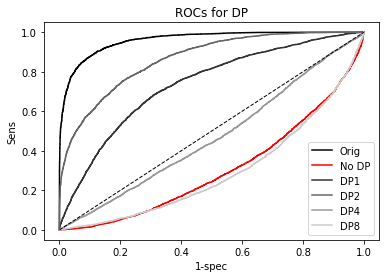

------------  ---------  --------  ----------  --------
True           5         10        -10         -5
Orig.          4.3127     8.8989    -8.77168   -4.3019
Synth, no DP   3.19753   -5.7831     0.18042   14.7011
DP 1          -2.07511   -3.0026    -0.379445   7.17053
DP 2           1.12212    6.83135   19.9633     3.88626
DP 4          -5.46788   -5.95798    8.37287   20.9923
DP 8           0.997225  -3.25346   34.6269    19.8237
------------  ---------  --------  ----------  --------


In [6]:
## Model fitted to original training data
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(cov_train,y_train)
ypred_test_orig=model.predict_proba(cov_test)[:,1]
beta_orig=model.coef_

## Model fitted to synthetic dataset with no DP guarantee
# Read in
s0_path=synth_path+"simple_logistic_0_"+synth_method+".csv"
print("Loading "+s0_path)
synth0 = np.loadtxt(s0_path, delimiter=",",skiprows=1)[:,1:]
# Fit model
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(synth0[:,0:p],synth0[:,p:(p+1)])
ypred_test_0=model.predict_proba(cov_test)[:,1]
beta_0=model.coef_

# Models fitted to DP datasets
ypred_test_dp=np.zeros([nx,len(dp_levels)])
beta_dp=np.zeros([p,len(dp_levels)])
for i in list(range(0,len(dp_levels))):
    dp=dp_levels[i]
    sdp=synth_path+"simple_logistic_"+str(dp)+"_"+synth_method+".csv"
    print("Loading "+sdp)
    synthd = np.loadtxt(sdp, delimiter=",",skiprows=1)[:,1:]
    # Fit model
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(synthd[:,0:p],synthd[:,p:(p+1)])
    ypred_test_d=model.predict_proba(cov_test)[:,1]
    ypred_test_dp[:,i]=ypred_test_d
    beta_dp[:,i]=model.coef_

## Plot ROC curves

# Original data
ss_orig=roc_xy(ypred_test_orig,y_test)
plt.plot(1-ss_orig[:,1],ss_orig[:,0],label="Orig",color="black")

# No DP
ss_0=roc_xy(ypred_test_0,y_test)
plt.plot(1-ss_0[:,1],ss_0[:,0],label="No DP",color="red")

# DP levels
for i in list(range(0,len(dp_levels))):
    ss_dp=roc_xy(ypred_test_dp[:,i],y_test)
    plt.plot(1-ss_dp[:,1],ss_dp[:,0],
             label="DP"+str(dp_levels[i]),
             color=str((i+1)/(len(dp_levels)+1)))

# X-Y line
plt.plot([0,1],[0,1],linestyle="--",linewidth=1,color="black")

# Draw plot
plt.title('ROCs for DP')
plt.xlabel('1-spec')
plt.ylabel('Sens')
plt.legend()

# Save figure
plt.savefig(output_path+'Figures/DP_ROC_'+synth_method+"_"+str(nx)+'.pdf', bbox_inches='tight')

# Show figure
plt.show()

# Print betas
btab=np.concatenate(
    (np.reshape(np.array(beta),(1,p)),
     beta_orig,
     beta_0,
     beta_dp))
rindex=["True","Orig.","Synth, no DP"] + ["DP "+str(d) for d in dp_levels]
print(tabulate(btab,showindex=rindex))

# Write to table
with open(output_path+'Tables/DP_beta_'+synth_method+'_'+str(nx)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(rindex)
    writer.writerows(np.transpose(btab))
    f.close()

